# Lab


In [1]:
# Built-in library
import asyncio
import json
import logging
import re
import warnings
from pathlib import Path
from pprint import pprint
from typing import (
    Annotated,
    Any,
    Generator,
    Iterable,
    Literal,
    Optional,
    TypedDict,
    Union,
)

# Standard imports
import nest_asyncio
import numpy as np
import numpy.typing as npt
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as pltife

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [3]:
go_up_from_current_directory(go_up=2)


from schemas import ModelEnum  # noqa: E402
from settings import refresh_settings  # noqa: E402
from utilities.client_utils import check_rate_limit  # noqa: E402

settings = refresh_settings()

/Users/neidu/Desktop/Projects/Personal/My_Projects/AI-Tutorials


In [4]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    AIMessage,
    AnyMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
)
from langchain_core.tools import InjectedToolCallId, tool
from langchain_litellm import ChatLiteLLM
from langchain_tavily import TavilySearch
from langfuse.langchain import CallbackHandler
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

In [70]:
from typing import Type

import instructor
from openai import AsyncOpenAI
from pydantic import BaseModel, Field

aclient = instructor.from_openai(
    AsyncOpenAI(
        api_key=settings.OPENROUTER_API_KEY.get_secret_value(),
        base_url=settings.OPENROUTER_URL,
    ),
    mode=instructor.Mode.JSON,
)


class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


class Person(BaseModel):
    name: str = Field(description="Name of the user")
    role: str = Field(description="Role of the user")


class PersonList(BaseModel):
    persons: list[Person] = Field(description="List of persons.")

In [71]:
model: str = ModelEnum.LLAMA_3p2_3B_INSTRUCT_REMOTE.value
input_msg: str = (
    "Extract all the persons: My name is Neidu. I am a software developer. "
    "Hey! I'm Dayo, a data scientist"
)

response = await aclient.chat.completions.create(
    model=model,
    response_model=PersonList,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": input_msg},
    ],
    max_retries=3,
    temperature=0.0,
    seed=1,
)

console.log(response)

[23:06:13] PersonList(                                                                             ]8;id=429812;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_28846/1622096579.py\1622096579.py]8;;\:]8;id=674919;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_28846/1622096579.py#19\19]8;;\
               persons=[                                                                                           
                   Person(name='Neidu', role='software developer'),                                                
                   Person(name='Dayo', role='data scientist')                                                      
               ]                                                                                                   
           )                                                                                                       

In [7]:
response = await aclient.chat.completions.create(
    model=model,
    response_model=None,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": input_msg},
    ],
    max_retries=3,
    temperature=0.0,
    seed=1,
)

console.log(response.choices[0].message.content)

[21:56:26] Nice to meet you, Neidu! As a software developer, I'm sure you're always looking for    ]8;id=284819;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_28846/1477099783.py\1477099783.py]8;;\:]8;id=120536;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_28846/1477099783.py#13\13]8;;\
           ways to improve your coding skills and stay up-to-date with the latest technologies. Is                 
           there something specific you'd like to chat about or ask for help with? Do you have a                   
           project you're working on that you'd like some guidance on? Or perhaps you're looking                   
           for recommendations on new tools or resources to learn? I'm here to help!                               

In [ ]:
class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# Format LangGraph messages for OpenAI
def to_openai_messages(messages: list[AnyMessage]) -> list[dict[str, str]]:
    formatted = []
    for msg in messages:
        if isinstance(msg, SystemMessage):
            formatted.append({"role": "system", "content": msg.content})
        elif isinstance(msg, AIMessage):
            formatted.append({"role": "assistant", "content": msg.content})
        elif isinstance(msg, ToolMessage):
            formatted.append(
                {
                    "role": "tool",
                    "content": msg.content,
                    "tool_call_id": msg.tool_call_id,
                }
            )
        else:
            formatted.append({"role": "user", "content": msg.content})
    return formatted


# Chatbot node
async def chatbot(state: MessageState) -> dict[str, Any]:
    messages = [SystemMessage(content="You are a helpful assistant.")] + state["messages"]
    openai_messages = to_openai_messages(messages)
    response = await aclient.chat.completions.create(
        model=ModelEnum.LLAMA_3p2_3B_INSTRUCT_REMOTE.value,
        response_model=None,
        messages=openai_messages,
        temperature=0.0,
        max_tokens=1_200,
        seed=42,
    )
    content = response.choices[0].message.content
    return {"messages": [AIMessage(content=content)]}

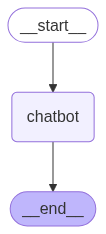

In [9]:
graph_builder = StateGraph(MessageState)

# Add nodes
graph_builder.add_node("chatbot", chatbot)

# Connect nodes
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Add memory
within_thread_memory = MemorySaver()

# Compile the graph
graph = graph_builder.compile(checkpointer=within_thread_memory).with_config(
    run_name="simple-chatbot"
)

# Visualize the graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [10]:
async def run_chat(inputs: list[str]):
    state = {"messages": [HumanMessage(content=msg) for msg in inputs]}
    config = {"configurable": {"thread_id": "1"}}

    async for event in graph.astream(state, config=config, stream_mode="values"):
        for msg in event["messages"]:
            msg.pretty_print()

In [11]:
await run_chat(["Hi, I'm Neidu"])

================================ Human Message =================================

Hi, I'm Neidu
================================ Human Message =================================

Hi, I'm Neidu
================================== Ai Message ==================================

Hi Neidu! It's nice to meet you. Is there something I can help you with or would you like to chat?


In [12]:
await run_chat(["How can I create AI agentic workflows?"])

================================ Human Message =================================

Hi, I'm Neidu
================================== Ai Message ==================================

Hi Neidu! It's nice to meet you. Is there something I can help you with or would you like to chat?
================================ Human Message =================================

How can I create AI agentic workflows?
================================ Human Message =================================

Hi, I'm Neidu
================================== Ai Message ==================================

Hi Neidu! It's nice to meet you. Is there something I can help you with or would you like to chat?
================================ Human Message =================================

How can I create AI agentic workflows?
================================== Ai Message ==================================

Creating AI-agentic workflows involves designing and implementing systems that enable machines to make decisions and take 

In [ ]:
await run_chat(["I want to apply it to my data. I want to generate insights from my data"])

In [22]:
from langchain_core.runnables.config import RunnableConfig
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

In [19]:
async def get_llm_response(
    messages: list[dict[str, Any]],
    response_model: Type[BaseModel] | None,
    model: str,
    max_tokens: int = 1_200,
) -> Type[BaseModel] | None:
    return await aclient.chat.completions.create(
        model=model,
        response_model=response_model,
        messages=messages,
        max_tokens=max_tokens,
        temperature=0.0,
        seed=42,
    )

In [ ]:
messages: list[dict[str, Any]] = [
    {"role": "system", "content": "You're a helpful assistant."},
    {"role": "user", "content": "Hi, I'm Neidu"},
]


await get_llm_response(
    messages=messages,
    response_model=None,
    model=ModelEnum.LLAMA_3p2_3B_INSTRUCT_REMOTE.value,
)

ChatCompletion(id='gen-1750022126-nvb3W7ynyl4p5tKIBRF0', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Hi Neidu! It's nice to meet you. Is there something I can help you with or would you like to chat?", refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None, reasoning=None), native_finish_reason='stop')], created=1750022126, model='meta-llama/llama-3.2-3b-instruct', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=28, prompt_tokens=29, total_tokens=57, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=None, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=None), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)), provider='Lambda')

In [132]:
class UserProfile(BaseModel):
    user_name: str = Field(description="User's name")
    interests: list[str] = Field(default_factory=list, description="User's interests")
    other_info: str = Field(default="", description="Other information about the user")


class Memory(BaseModel):
    content: str = Field(description="The main content of the memory.")


class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(
        description="A list of memories.", default_factory=[]
    )


# Chatbot instruction
MODEL_SYSTEM_MESSAGE: str = """
<system>

<role>
You are a helpful assistant with memory that provides information about the user.
If you have memory for this user, use it to personalize your responses.
</role>

<memory>
{memory}
</memory>

<quality_standards>
- **ALWAYS** use the information in memory.
- Do not display the memory with the XML format directly to the user.
</quality_standards>

</system>
"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION: str = """"
<system>

<role>
You are collecting information about the user to personalize your responses.
</role>

<current_user_info>
{memory}
</current_user_info>

<instruction>
1. If there's exisiting memory, simply update it.
2. If new information conflicts with existing memory, keep the most recent version.
Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.
</instruction>

Based on the chat history below, please update the user information:

<system>
"""

In [133]:
async def call_llm(
    state: MessageState, config: RunnableConfig, store: BaseStore
) -> dict[str, Any]:
    # Get the user id
    user_id = config["configurable"]["user_id"]

    # Get the memory for the user
    prefix: str = "memory"
    key = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.get(namespace, key)
    # existing_memory = await store.aget(namespace, key)

    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}\n"
        )
    else:
        formatted_memory = None

    system_message: str = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)
    # Respond using memory + chat history
    messages = to_openai_messages(
        [SystemMessage(content=system_message)] + state["messages"]
    )
    response = await get_llm_response(
        messages=messages,
        response_model=None,
        model=ModelEnum.LLAMA_3p2_3B_INSTRUCT_REMOTE.value,
    )
    content = response.choices[0].message.content

    return {"messages": [AIMessage(content=content)]}


async def write_memory(
    state: MessageState, config: RunnableConfig, store: BaseStore
) -> None:
    user_id = config["configurable"]["user_id"]
    prefix: str = "memory"
    key = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.get(namespace, key)
    # existing_memory = await store.aget(namespace, key)

    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}\n"
        )
    else:
        formatted_memory = None

    system_message: str = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)
    # Respond using memory + chat history
    messages = to_openai_messages(
        [SystemMessage(content=system_message)] + state["messages"]
    )
    new_memory = await get_llm_response(
        messages=messages,
        response_model=UserProfile,
        model=ModelEnum.LLAMA_3p2_3B_INSTRUCT_REMOTE.value,
    )

    # Update existing memory
    # await store.aput(namespace, key, {prefix: new_memory.content})
    store.put(namespace, key, {prefix: new_memory.model_dump()})

In [134]:
mem = InMemoryStore()

namespace = ("memory", "1")
key: str = "sample_memory"
value: dict[str, Any] = {"user_name": "Neidu", "interests": ["LangGraph"]}

mem.put(namespace, key, value)

In [135]:
namespace = ("memory", "1")
key: str = "sample_memory"

ex_memory = mem.search(namespace)
console.log(ex_memory)

[23:29:44] [                                                                                        ]8;id=269961;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_28846/1390856903.py\1390856903.py]8;;\:]8;id=41809;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_28846/1390856903.py#5\5]8;;\
               Item(namespace=['memory', '1'], key='sample_memory', value={'user_name': 'Neidu',                   
           'interests': ['LangGraph']}, created_at='2025-06-15T22:29:43.257251+00:00',                             
           updated_at='2025-06-15T22:29:43.257256+00:00', score=None)                                              
           ]                                                                                                       

In [136]:
[row.value for row in ex_memory]

[{'user_name': 'Neidu', 'interests': ['LangGraph']}]

In [163]:
async def call_llm(
    state: MessageState, config: RunnableConfig, store: BaseStore
) -> dict[str, Any]:
    # Get the user id
    user_id = config["configurable"]["user_id"]

    # Get the memory for the user
    prefix: str = "memory"
    namespace = (prefix, user_id)
    existing_memory = store.search(namespace)

    formatted_memory = (
        "\n".join([f"- {memory.value['memory']}" for memory in existing_memory])
        if existing_memory
        else None
    )

    system_message: str = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)
    # Respond using memory + chat history
    messages = to_openai_messages(
        [SystemMessage(content=system_message)] + state["messages"]
    )
    response = await get_llm_response(
        messages=messages,
        response_model=None,
        model=ModelEnum.QWEN_3p0_8B_REMOTE.value,
    )
    content = response.choices[0].message.content

    return {"messages": [AIMessage(content=content)]}


async def write_memory(
    state: MessageState, config: RunnableConfig, store: BaseStore
) -> None:
    user_id = config["configurable"]["user_id"]
    prefix: str = "memory"
    key = "user_memory"
    namespace = (prefix, user_id)
    existing_memory = store.search(namespace)

    formatted_memory = (
        "\n".join([f"- {memory.value['memory']}" for memory in existing_memory])
        if existing_memory
        else None
    )

    system_message: str = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)
    # Respond using memory + chat history
    messages = to_openai_messages(
        [SystemMessage(content=system_message)] + state["messages"]
    )
    new_memory = await get_llm_response(
        messages=messages,
        response_model=MemoryCollection,
        model=ModelEnum.QWEN_3p0_8B_REMOTE.value,
    )

    # Update existing memory
    # await store.aput(namespace, key, {prefix: new_memory.content})
    store.put(namespace, key, {prefix: new_memory.model_dump()})

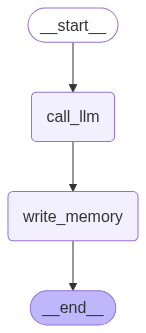

In [164]:
# Graph
graph_builder = StateGraph(MessageState)

# Add nodes
graph_builder.add_node("call_llm", call_llm)
graph_builder.add_node("write_memory", write_memory)

# Add edges
graph_builder.add_edge(START, "call_llm")
graph_builder.add_edge("call_llm", "write_memory")
graph_builder.add_edge("write_memory", END)

# Long-term-memory store (across threads)
across_thread_memory = InMemoryStore()
# Short-term-memory store (within a thread) checkpointer
within_thread_memory = MemorySaver()

# Compile
graph = graph_builder.compile(
    checkpointer=within_thread_memory, store=across_thread_memory
).with_config(run_name="chatbot-with-structured-memory")

# Visualize
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [165]:
async def run_chat(inputs: list[str]):
    state = {"messages": [HumanMessage(content=msg) for msg in inputs]}
    config = {"configurable": {"thread_id": "1", "user_id": "1"}}

    async for event in graph.astream(state, config=config, stream_mode="values"):
        for msg in event["messages"]:
            msg.pretty_print()

In [166]:
inputs: list[str] = ["Hi, I'm Neidu"]
graph_input = {"messages": [HumanMessage(content=msg) for msg in inputs]}
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

async for event in graph.astream(graph_input, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hi, I'm Neidu
================================ Human Message =================================

Hi, I'm Neidu
================================== Ai Message ==================================

Hello, Neidu! How can I assist you today?


In [167]:
inputs: list[str] = ["What do you know about LangGraph?"]
graph_input = {"messages": [HumanMessage(content=msg) for msg in inputs]}

async for event in graph.astream(graph_input, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hi, I'm Neidu
================================== Ai Message ==================================

Hello, Neidu! How can I assist you today?
================================ Human Message =================================

What do you know about LangGraph?
================================ Human Message =================================

Hi, I'm Neidu
================================== Ai Message ==================================

Hello, Neidu! How can I assist you today?
================================ Human Message =================================

What do you know about LangGraph?
================================== Ai Message ==================================

LangGraph is a framework developed by the LangChain team to help build applications that use large language models (LLMs) in a structured and scalable way. It allows users to define workflows by chaining together different steps or functions, suc

In [168]:
inputs: list[str] = ["How can I create AI agentic workflows?"]
graph_input = {"messages": [HumanMessage(content=msg) for msg in inputs]}

async for event in graph.astream(graph_input, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hi, I'm Neidu
================================== Ai Message ==================================

Hello, Neidu! How can I assist you today?
================================ Human Message =================================

What do you know about LangGraph?
================================== Ai Message ==================================

LangGraph is a framework developed by the LangChain team to help build applications that use large language models (LLMs) in a structured and scalable way. It allows users to define workflows by chaining together different steps or functions, such as data processing, model inference, or decision-making, into a graph-like structure. This makes it easier to manage complex interactions between LLMs and other tools or data sources.

Key features of LangGraph include:
- **State Management**: Tracking and persisting the state of conversations or processes across multiple steps.
- *

In [169]:
# Chat history
state = graph.get_state(config=config).values

for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi, I'm Neidu
================================== Ai Message ==================================

Hello, Neidu! How can I assist you today?
================================ Human Message =================================

What do you know about LangGraph?
================================== Ai Message ==================================

LangGraph is a framework developed by the LangChain team to help build applications that use large language models (LLMs) in a structured and scalable way. It allows users to define workflows by chaining together different steps or functions, such as data processing, model inference, or decision-making, into a graph-like structure. This makes it easier to manage complex interactions between LLMs and other tools or data sources.

Key features of LangGraph include:
- **State Management**: Tracking and persisting the state of conversations or processes across multiple steps.
- *

In [173]:
# namespace for the memory to save
user_id: str = "1"
prefix: str = "memory"
namespace = (prefix, user_id)
existing_memory = across_thread_memory.search(namespace)
console.log(existing_memory)

[00:25:06] [                                                                                        ]8;id=521469;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_28846/1731364959.py\1731364959.py]8;;\:]8;id=538980;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_28846/1731364959.py#6\6]8;;\
               Item(namespace=['memory', '1'], key='user_memory', value={'memory': {'memories':                    
           [{'content': "Hi, I'm Neidu"}, {'content': 'What do you know about LangGraph?'}]}},                     
           created_at='2025-06-15T23:24:32.164360+00:00',                                                          
           updated_at='2025-06-15T23:24:32.164366+00:00', score=None)                                              
           ]                                                                                                       

In [ ]:
inputs: list[str] = ["What was my first question?"]
graph_input = {"messages": [HumanMessage(content=msg) for msg in inputs]}

async for event in graph.astream(graph_input, config=config, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hi, I'm Neidu
================================== Ai Message ==================================

Hello, Neidu! How can I assist you today?
================================ Human Message =================================

What do you know about LangGraph?
================================== Ai Message ==================================

LangGraph is a framework developed by the LangChain team to help build applications that use large language models (LLMs) in a structured and scalable way. It allows users to define workflows by chaining together different steps or functions, such as data processing, model inference, or decision-making, into a graph-like structure. This makes it easier to manage complex interactions between LLMs and other tools or data sources.

Key features of LangGraph include:
- **State Management**: Tracking and persisting the state of conversations or processes across multiple steps.
- *

In [175]:
inputs: list[str] = ["What do you know about me?"]
graph_input = {"messages": [HumanMessage(content=msg) for msg in inputs]}
config_2 = {"configurable": {"thread_id": "1", "user_id": "2"}}

async for event in graph.astream(graph_input, config=config_2, stream_mode="values"):
    for msg in event["messages"]:
        msg.pretty_print()

================================ Human Message =================================

Hi, I'm Neidu
================================== Ai Message ==================================

Hello, Neidu! How can I assist you today?
================================ Human Message =================================

What do you know about LangGraph?
================================== Ai Message ==================================

LangGraph is a framework developed by the LangChain team to help build applications that use large language models (LLMs) in a structured and scalable way. It allows users to define workflows by chaining together different steps or functions, such as data processing, model inference, or decision-making, into a graph-like structure. This makes it easier to manage complex interactions between LLMs and other tools or data sources.

Key features of LangGraph include:
- **State Management**: Tracking and persisting the state of conversations or processes across multiple steps.
- *

In [179]:
# namespace for the memory to save
user_id: str = "1"
prefix: str = "memory"
namespace = (prefix, user_id)
existing_memory = across_thread_memory.search(namespace)
console.log(existing_memory)

[00:30:20] [                                                                                        ]8;id=710199;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_28846/1731364959.py\1731364959.py]8;;\:]8;id=890171;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_28846/1731364959.py#6\6]8;;\
               Item(namespace=['memory', '1'], key='user_memory', value={'memory': {'memories':                    
           [{'content': "Hi, I'm Neidu"}, {'content': 'What do you know about LangGraph?'},                        
           {'content': 'How can I create AI agentic workflows?'}, {'content': 'What was my first                   
           question?'}]}}, created_at='2025-06-15T23:26:23.533687+00:00',                                          
           updated_at='2025-06-15T23:26:23.533692+00:00', score=None)                                              
           ]                                                                                                       